# Libraries

In [1]:
import matplotlib.pyplot as plt
import yaml
import time
import re
import os
import numpy as np
import librosa
import models
import torch
import torch.nn as nn
import torch.optim as optimizer
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import gamma
from data_bundler import DataBundler
from torch.utils.data import DataLoader
from torch.nn.functional import mse_loss
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from matplotlib.backends.backend_pdf import PdfPages

# Hyper Parameters

In [2]:
def load_hyper_parameters():
    with open("hyper_parameters.yaml", 'r') as file:
        return yaml.safe_load(file)

In [3]:
hyper_parameters = load_hyper_parameters()

#> Acoustic Features
acoustic_features = hyper_parameters['acoustic_features']
number_of_mels = acoustic_features['number_of_mels']
number_of_frames_to_concatenate = acoustic_features['number_of_frames_to_concatenate']
frame_size_seconds = acoustic_features['frame_size_seconds']
frame_size_samples = acoustic_features['frame_size_samples']
hop_size_seconds = acoustic_features['hop_size_seconds']
hop_size_samples = acoustic_features['hop_size_samples']


#> Dataset Parameters
dataset_paremeters = hyper_parameters['dataset_parameters']
train_data_inclusion_string = dataset_paremeters['train_data_inclusion_string']
test_data_inclusion_string = dataset_paremeters['test_data_inclusion_string']
train_pct = dataset_paremeters['train_pct']
test_pct = dataset_paremeters['test_pct']


#> Training Parameters
training_parameters = hyper_parameters['training_parameters']
batch_size = training_parameters['batch_size']
epochs = training_parameters['epochs']
learning_rate = training_parameters['learning_rate']
shuffle = training_parameters['shuffle']

# Loading Datasets

In [4]:
data_bundler = DataBundler()
number_of_top_frequiences = 10

print("Training Data")
training_data, training_filenames, training_clip_lengths = data_bundler.load_dataset(train_data_inclusion_string, train_pct, number_of_top_frequiences)
number_of_training_data = len(training_data)

print("Testing Data")
testing_data, testing_filenames, testing_clip_lengths = data_bundler.load_dataset(test_data_inclusion_string, test_pct, number_of_top_frequiences)
number_of_testing_data = len(testing_data)

Training Data


Processing audio files: 100%|██████████| 1000/1000 [00:08<00:00, 122.49file/s]


Done loading!
Length of dataset: 75000

Testing Data


Processing audio files: 100%|██████████| 200/200 [00:01<00:00, 149.45file/s]


Done loading!
Length of dataset: 15000



# Selecting Device

In [5]:
!nvidia-smi

Fri May 16 12:55:12 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 576.02                 Driver Version: 576.02         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1650      WDDM  |   00000000:01:00.0  On |                  N/A |
| 56%   34C    P8             10W /   75W |    1175MiB /   4096MiB |     21%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [6]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2"

print("CUDA available:", torch.cuda.is_available())
print("Number of GPUs:", torch.cuda.device_count())
print("Current device:", torch.cuda.current_device() if torch.cuda.is_available() else "CPU")
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "N/A")

if torch.cuda.is_available():
    # Check if CUDA device 2 is available
    if torch.cuda.device_count() > 2:
        device = torch.device("cuda:2")
        torch.cuda.set_device(device)
    else:
        device = torch.device("cuda:0")
        torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

CUDA available: True
Number of GPUs: 1
Current device: 0
Device name: NVIDIA GeForce GTX 1650
Using device: cuda:0


# Training

In [7]:
model = models.AF_Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

training_dataset = torch.tensor(training_data, dtype=torch.float32)
training_input_features = DataLoader(training_dataset, batch_size=batch_size, shuffle=shuffle)
training_data

array([[-29.001337, -38.508263, -38.707497, ..., -78.53834 , -73.39421 ,
        -74.979935],
       [-41.215794, -40.09104 , -37.440796, ..., -73.22572 , -75.55876 ,
        -74.920555],
       [-42.373592, -41.981453, -38.886322, ..., -75.061905, -76.279526,
        -77.393166],
       ...,
       [-35.191624, -39.029636, -34.802593, ..., -76.58244 , -69.89762 ,
        -72.668335],
       [-36.035355, -40.724674, -37.951187, ..., -74.19097 , -76.98289 ,
        -76.13437 ],
       [-36.925095, -41.41696 , -38.016228, ..., -69.90979 , -72.09432 ,
        -70.55296 ]], shape=(75000, 640), dtype=float32)

In [8]:
training_losses = []

def train_model():
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for data in training_input_features:
            input = data.to(device)
            optimizer.zero_grad()

            output = model(input)
            loss = criterion(output, input)

            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(training_input_features)
        training_losses.append(avg_loss)

        elapsed_time = time.time() - start_time
        print(f"Epoch [{epoch + 1}/{epochs}] ({elapsed_time:.2f}s) | Loss: {avg_loss:.4f}")

    model.eval()

In [9]:
train_model()

Epoch [1/100] (2.00s) | Loss: 334.6440
Epoch [2/100] (3.87s) | Loss: 16.2176
Epoch [3/100] (5.96s) | Loss: 11.9609
Epoch [4/100] (7.90s) | Loss: 11.1750
Epoch [5/100] (9.83s) | Loss: 10.6507
Epoch [6/100] (11.76s) | Loss: 10.2579
Epoch [7/100] (13.73s) | Loss: 10.1246
Epoch [8/100] (15.59s) | Loss: 10.0172
Epoch [9/100] (17.44s) | Loss: 9.9329
Epoch [10/100] (19.39s) | Loss: 9.8769
Epoch [11/100] (21.43s) | Loss: 9.8323
Epoch [12/100] (23.47s) | Loss: 9.7780
Epoch [13/100] (25.53s) | Loss: 9.6910
Epoch [14/100] (27.62s) | Loss: 9.6964
Epoch [15/100] (29.48s) | Loss: 9.6014
Epoch [16/100] (31.32s) | Loss: 9.5742
Epoch [17/100] (33.19s) | Loss: 9.5247
Epoch [18/100] (35.06s) | Loss: 9.4550
Epoch [19/100] (36.93s) | Loss: 9.4093
Epoch [20/100] (39.03s) | Loss: 9.3435
Epoch [21/100] (40.87s) | Loss: 9.2861
Epoch [22/100] (42.84s) | Loss: 9.2781
Epoch [23/100] (44.91s) | Loss: 9.2867
Epoch [24/100] (47.29s) | Loss: 9.2270
Epoch [25/100] (49.26s) | Loss: 9.2152
Epoch [26/100] (51.21s) | Loss

# Evaluating

In [10]:
testing_dataset = torch.tensor(testing_data, dtype=torch.float32)
testing_input_features = DataLoader(testing_dataset, batch_size=batch_size, shuffle=shuffle)
testing_data

array([[-20.670443, -40.78655 , -45.61207 , ..., -72.00201 , -76.46904 ,
        -72.88356 ],
       [-36.465134, -38.228798, -40.138916, ..., -76.42061 , -71.7777  ,
        -74.00899 ],
       [-39.129776, -36.865643, -40.715034, ..., -69.29277 , -73.64197 ,
        -77.22248 ],
       ...,
       [-37.917816, -34.217323, -36.5     , ..., -73.99164 , -76.16498 ,
        -77.501724],
       [-36.080242, -36.552124, -38.881073, ..., -73.093735, -73.18933 ,
        -75.2688  ],
       [-35.881737, -35.709736, -38.559723, ..., -75.391785, -75.13675 ,
        -74.29911 ]], shape=(15000, 640), dtype=float32)

In [11]:
testing_output_features = []
mse_list = []

def evaluate_model():
    model.eval()
    total_mse = 0.0
    total_samples = 0

    with torch.no_grad():
        for data in testing_input_features:
            input = data.to(device)
            output = model(input)

            testing_output_features.append(output.cpu().numpy())  # Store the reconstruction for later use

            mse = mse_loss(output, input, reduction='sum').item()
            mse_list.append(mse)
            total_mse += mse
            total_samples += input.numel()
            
    average_mse = total_mse / total_samples
    print(f"Average MSE: {average_mse:.4f}")

In [12]:
evaluate_model()
print(testing_output_features)
testing_output_features = np.vstack(testing_output_features)

Average MSE: 9.0391
[array([[-37.083477, -37.427505, -37.167717, ..., -56.218277, -57.19248 ,
        -57.331993],
       [-36.54283 , -36.543816, -36.242443, ..., -54.293262, -54.252064,
        -54.459297],
       [-35.590927, -35.779903, -35.83226 , ..., -64.15363 , -63.54251 ,
        -64.362206],
       ...,
       [-36.70881 , -36.91289 , -36.839584, ..., -50.29478 , -50.47522 ,
        -50.145935],
       [-38.17783 , -38.6564  , -38.461803, ..., -75.51249 , -75.64922 ,
        -75.82365 ],
       [-36.009457, -36.684143, -36.25358 , ..., -60.04227 , -60.39578 ,
        -60.52343 ]], shape=(256, 640), dtype=float32), array([[-36.895893, -37.303055, -37.074417, ..., -60.32643 , -60.28386 ,
        -59.649868],
       [-38.938156, -38.25451 , -38.944183, ..., -58.836456, -58.586197,
        -58.30804 ],
       [-36.104797, -36.293354, -35.925316, ..., -54.764847, -54.60202 ,
        -54.763077],
       ...,
       [-35.62557 , -36.52344 , -36.307777, ..., -73.670265, -73.67313 ,
 

In [13]:
testing_output_features

array([[-37.083477, -37.427505, -37.167717, ..., -56.218277, -57.19248 ,
        -57.331993],
       [-36.54283 , -36.543816, -36.242443, ..., -54.293262, -54.252064,
        -54.459297],
       [-35.590927, -35.779903, -35.83226 , ..., -64.15363 , -63.54251 ,
        -64.362206],
       ...,
       [-35.882103, -35.921146, -35.759647, ..., -49.96647 , -50.30783 ,
        -49.64822 ],
       [-35.620934, -35.455425, -35.46111 , ..., -52.948227, -53.286396,
        -53.044205],
       [-36.746033, -36.58462 , -36.845703, ..., -62.371586, -61.881588,
        -62.53806 ]], shape=(15000, 640), dtype=float32)

In [14]:
np.mean((testing_data - testing_output_features)**2)

np.float32(106.56294)

## Reconstructions

In [15]:
original_clips = []

start_index = 0

for size in testing_clip_lengths:
    end_index = start_index + size
    original_clips.append(testing_data[start_index:end_index])
    start_index = end_index

In [16]:
original_clips[0]

array([[-20.670443, -40.78655 , -45.61207 , ..., -72.00201 , -76.46904 ,
        -72.88356 ],
       [-36.465134, -38.228798, -40.138916, ..., -76.42061 , -71.7777  ,
        -74.00899 ],
       [-39.129776, -36.865643, -40.715034, ..., -69.29277 , -73.64197 ,
        -77.22248 ],
       ...,
       [-36.420036, -38.654533, -38.793854, ..., -71.97069 , -75.585915,
        -73.20706 ],
       [-38.767685, -42.006958, -40.995827, ..., -72.39771 , -72.70064 ,
        -75.18748 ],
       [-36.956573, -40.931557, -38.781353, ..., -78.90036 , -71.31298 ,
        -74.86913 ]], shape=(75, 640), dtype=float32)

In [17]:
reconstructed_clips = []
start_index = 0

for size in testing_clip_lengths:
    end_index = start_index + size
    reconstructed_clips.append(testing_output_features[start_index:end_index])
    start_index = end_index

In [18]:
recon_err_per_clip = []
for i in range(len(reconstructed_clips)):
    item1 = reconstructed_clips[i].reshape(-1)
    item2 = original_clips[i].reshape(-1)
    
    recon_err_per_clip.append(np.mean((item1 - item2)**2))

In [19]:
# clip = original_clips[0]  # shape (65, 650)

# # Extract last 10 columns
# last_top_columns = clip[:, -number_of_top_frequiences:]  # shape (65, 10)

# # Convert each column to a single value (e.g., mean across rows)
# last_top_list = list(np.mean(last_top_columns, axis=0))  # length 10 list

# # Keep the first 640 columns
# clip_trimmed = clip[:, :-number_of_top_frequiences]  # shape (65, 640)

# print(clip_trimmed.shape)  # (65, 640)
# print(len(last_top_list))   # 10


In [20]:
from audio_converter import AudioConverter
audio_converter = AudioConverter()

audio_clip_index = 0

original_input = audio_converter.output_to_mel(original_clips[0])
original_input

array([[-20.670443, -40.78655 , -45.61207 , ..., -38.781353, -38.261772,
        -39.897247],
       [-16.55252 , -33.013138, -29.827753, ..., -30.150694, -30.096384,
        -26.65318 ],
       [-10.654613, -14.199468, -18.340414, ..., -15.949503, -18.615818,
        -16.025383],
       ...,
       [-58.823204, -60.10737 , -60.43483 , ..., -56.856636, -59.59694 ,
        -57.597664],
       [-62.149513, -62.40728 , -62.530098, ..., -59.036537, -60.46972 ,
        -58.30085 ],
       [-64.91661 , -71.27526 , -72.00201 , ..., -78.90036 , -71.31298 ,
        -74.86913 ]], shape=(128, 375), dtype=float32)

In [21]:
# clip = reconstructed_clips[0]  # shape (65, 650)

# # Extract last 10 columns
# last_10_columns = clip[:, -10:]  # shape (65, 10)

# # Convert each column to a single value (e.g., mean across rows)
# last_10_list = list(np.mean(last_10_columns, axis=0))  # length 10 list

# # Keep the first 640 columns
# clip_trimmed = clip[:, :-10]  # shape (65, 640)

# print(clip_trimmed.shape)  # (65, 640)
# print(len(last_10_list))   # 10


In [22]:
recreated_output = audio_converter.output_to_mel(reconstructed_clips[0])

error_mel = original_input - recreated_output

In [23]:
# from audio_converter import AudioConverter
# audio_converter = AudioConverter()

# audio_clip_index = 0

# original_input = audio_converter.output_to_mel(original_clips[audio_clip_index])
# recreated_output = audio_converter.output_to_mel(reconstructed_clips[audio_clip_index])

# error_mel = original_input - recreated_output

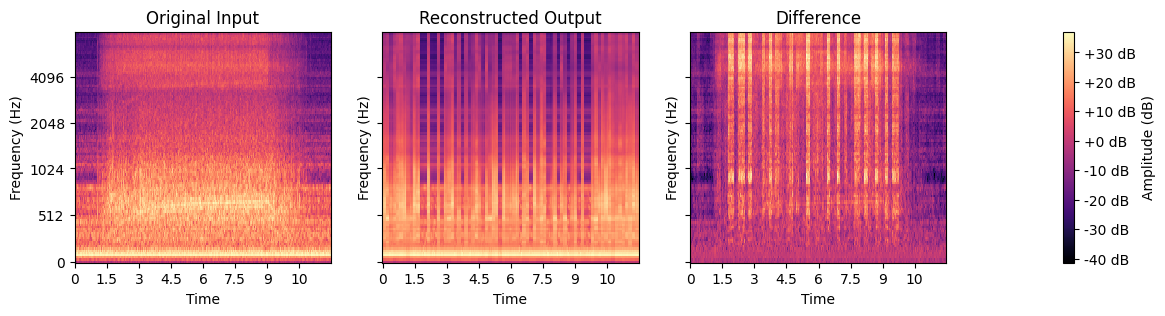

In [24]:
spectrogram_figures, axes = plt.subplots(1, 3, figsize=(15, 3), sharex=True, sharey=True)

# Plot each spectrogram
spectrograms = [original_input, recreated_output, error_mel]
titles = ['Original Input', 'Reconstructed Output', 'Difference']

for ax, spectrogram, title in zip(axes, spectrograms, titles):
    img = librosa.display.specshow(
        spectrogram,
        sr=16000,
        x_axis='time',
        y_axis='mel',
        cmap='magma',
        ax=ax
    )
    ax.set_title(title)
    ax.set_xlabel('Time')
    ax.set_ylabel('Frequency (Hz)')

cbar = spectrogram_figures.colorbar(img, ax=axes, format='%+2.0f dB', location='right', pad=0.1)
cbar.set_label('Amplitude (dB)')

# Adjust spacing
# plt.tight_layout()
plt.show()

In [25]:
testing_dataset = torch.tensor(testing_data, dtype=torch.float32)
testing_input_features = DataLoader(testing_dataset, batch_size=batch_size, shuffle=shuffle)
testing_data

array([[-20.670443, -40.78655 , -45.61207 , ..., -72.00201 , -76.46904 ,
        -72.88356 ],
       [-36.465134, -38.228798, -40.138916, ..., -76.42061 , -71.7777  ,
        -74.00899 ],
       [-39.129776, -36.865643, -40.715034, ..., -69.29277 , -73.64197 ,
        -77.22248 ],
       ...,
       [-37.917816, -34.217323, -36.5     , ..., -73.99164 , -76.16498 ,
        -77.501724],
       [-36.080242, -36.552124, -38.881073, ..., -73.093735, -73.18933 ,
        -75.2688  ],
       [-35.881737, -35.709736, -38.559723, ..., -75.391785, -75.13675 ,
        -74.29911 ]], shape=(15000, 640), dtype=float32)

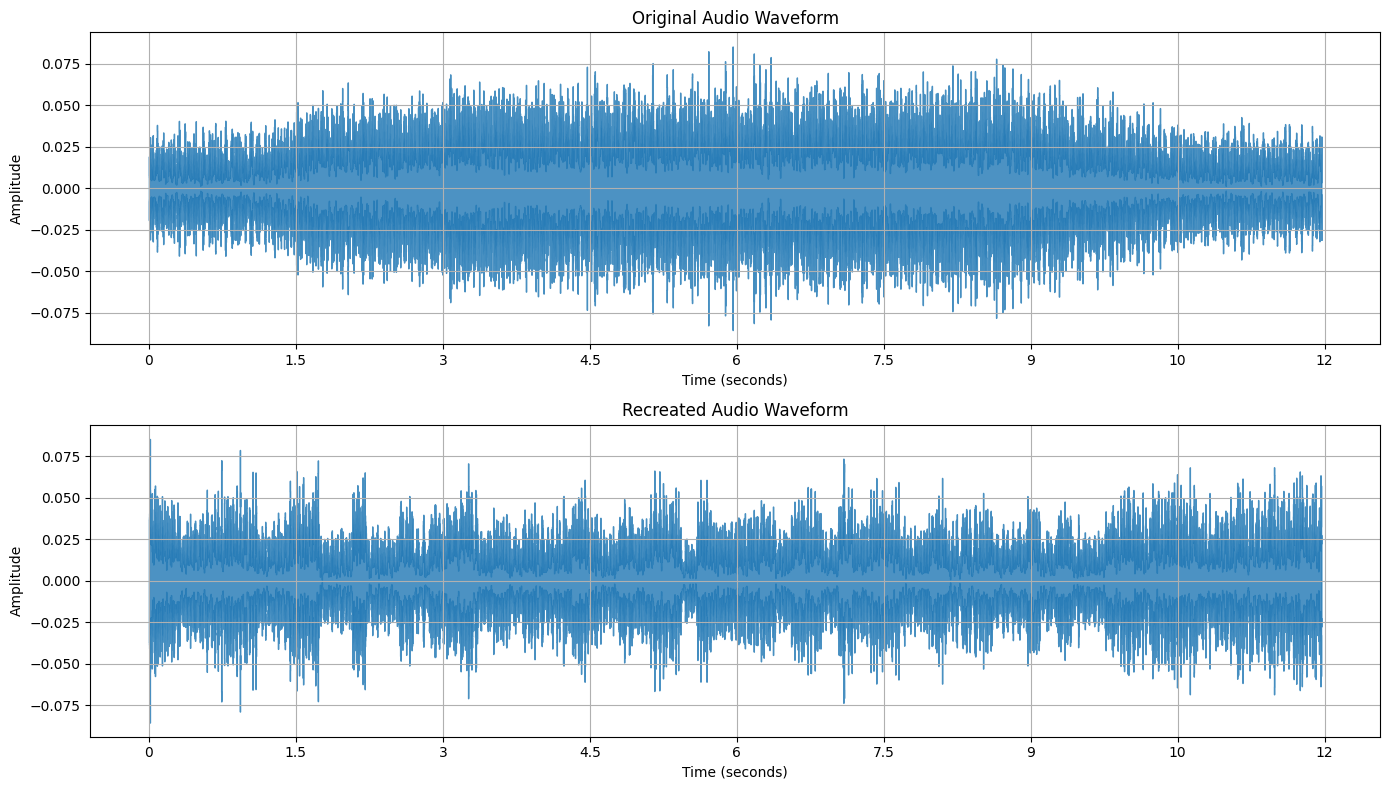

In [26]:
original_wav = audio_converter.mel_to_wav(original_input)
recreated_wav = audio_converter.mel_to_wav(recreated_output)

# Create a figure with subplots
plt.figure(figsize=(14, 8))

# Plot the original audio
plt.subplot(2, 1, 1)
librosa.display.waveshow(original_wav, sr=16000, alpha=0.8)
plt.title("Original Audio Waveform")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.grid()

# Plot the recreated audio
plt.subplot(2, 1, 2)
librosa.display.waveshow(recreated_wav, sr=16000, alpha=0.8)
plt.title("Recreated Audio Waveform")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.grid()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [27]:
import soundfile as sf

# Save the original audio as a .wav file
sf.write("reconstructions/original.wav", original_wav, 16000)

# Save the recreated audio as a .wav file
sf.write("reconstructions/recreated.wav", recreated_wav, 16000)

# Results

## Preparation for Visualization

In [28]:
epochs_range = range(1, epochs + 1)

In [29]:
status_list = []
pattern = r"_(normal|anomaly)_"

for line in testing_filenames:
    match = re.search(pattern, line)
    if match:
        status_list.append(match.group(1))

# print(len(status_list))
# status_list

In [30]:
output_with_true_labels = list(zip(status_list, recon_err_per_clip))
sorted_output = sorted(output_with_true_labels, key=lambda x: x[1], reverse=True)
labels, values = zip(*sorted_output)

In [31]:
colors = ['blue' if label == "normal" else 'red' for label in labels]

binary_labels = [1 if label == 'anomaly' else 0 for label in status_list]
# print(binary_labels)

In [32]:
shape, loc, scale = gamma.fit(recon_err_per_clip)

x = np.linspace(0, max(values), 1000)
gamma_pdf = gamma.pdf(x, shape, loc=loc, scale=scale)

anomaly_threshold = gamma.ppf(0.9, shape, loc=loc, scale=scale)
# print(f"Anomaly threshold: {anomaly_threshold}")

In [33]:
anomaly_labels = (values > anomaly_threshold).astype(int)

cm = confusion_matrix(binary_labels, anomaly_labels.astype(int))

TN, FP, FN, TP = cm.ravel()

fpr = FP / (FP + TN) if (FP + TN) > 0 else 0
fnr = FN / (FN + TP) if (FN + TP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
accuracy = (TP + TN) / (TP + TN + FP + FN)

In [34]:
roc_fpr, roc_tpr, thresholds = roc_curve(binary_labels, values)
auc_score = auc(roc_fpr, roc_tpr)

# Visualizations

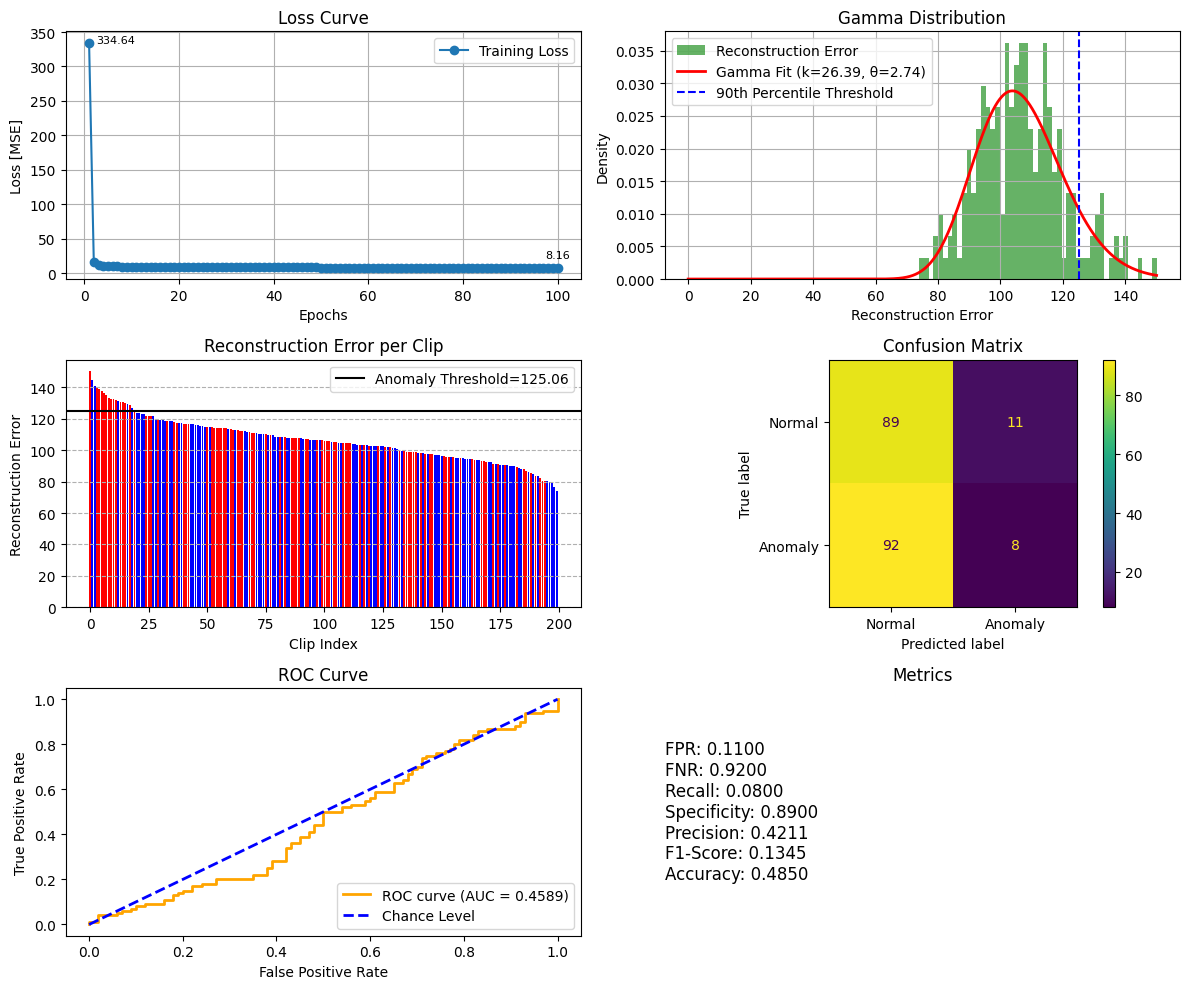

In [35]:
combined_results_figure, axes = plt.subplots(3,2, figsize=(12, 10))
axes = axes.flatten()


#> Loss Curve
axes[0].plot(epochs_range, training_losses, label='Training Loss', marker='o')
axes[0].annotate(
    f'{training_losses[0]:.2f}',
    (epochs_range[0], training_losses[0]),
    textcoords="offset points",
    xytext=(5,0),
    ha='left',
    fontsize=8
)
axes[0].annotate(
    f'{training_losses[-1]:.2f}',
    (epochs_range[-1], training_losses[-1]),
    textcoords="offset points",
    xytext=(0,7),
    ha='center',
    fontsize=8
)
axes[0].set_title('Loss Curve')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss [MSE]')
axes[0].legend()
axes[0].grid()


#> Gamma Distribution
axes[1].hist(values, bins=50, density=True, color='green', alpha=0.6, label='Reconstruction Error')
axes[1].plot(x, gamma_pdf, 'r-', lw=2, label=f'Gamma Fit (k={shape:.2f}, θ={scale:.2f})')
axes[1].axvline(gamma.ppf(0.90, shape, loc=loc, scale=scale), color='b', linestyle='--', label='90th Percentile Threshold')
axes[1].set_title('Gamma Distribution')
axes[1].set_xlabel('Reconstruction Error')
axes[1].set_ylabel('Density')
axes[1].legend()
axes[1].grid(True)


#> Reconstruction Errors
axes[2].axhline(y=anomaly_threshold, color='black', linestyle='-', label=f'Anomaly Threshold={anomaly_threshold:.2f}')
axes[2].bar(range(len(values)), values, color=colors)
axes[2].set_title('Reconstruction Error per Clip')
axes[2].set_xlabel('Clip Index')
axes[2].set_ylabel('Reconstruction Error')
axes[2].legend()
axes[2].grid(axis='y', linestyle='--')


#> Confusion Matrix
confusion_matrix = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anomaly"])
confusion_matrix.plot(cmap='viridis', ax=axes[3])
axes[3].set_title("Confusion Matrix")


#> ROC Curve
axes[4].plot(roc_fpr, roc_tpr, color='orange', lw=2, label=f'ROC curve (AUC = {auc_score:.4f})')
axes[4].plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--', label='Chance Level')
axes[4].set_title('ROC Curve')
axes[4].set_xlabel('False Positive Rate')
axes[4].set_ylabel('True Positive Rate')
axes[4].legend(loc='lower right')
axes[1].grid(True)


#> Metrics
metrics = f"FPR: {fpr:.4f}\nFNR: {fnr:.4f}\nRecall: {recall:.4f}\nSpecificity: {specificity:.4f}\nPrecision: {precision:.4f}\nF1-Score: {f1_score:.4f}\nAccuracy: {accuracy:.4f}"""
axes[5].axis('off')
axes[5].text(0, 0.5, metrics, fontsize=12, va='center', wrap=True)
axes[5].set_title("Metrics")


#> Show the plots
combined_results_figure.tight_layout()
plt.show()

# Saving Model and Results

In [36]:
folder_name = "saved_models"
os.makedirs(folder_name, exist_ok=True)

existing_files = [f for f in os.listdir(folder_name) if f.endswith('.pth')]
file_number = len(existing_files) + 1
pth_filename = os.path.join(folder_name, f"saved_model_{file_number}.pth")

torch.save(model.state_dict(), pth_filename)

In [37]:
#> Preparing folder and filename for PDF
folder_name = "training_results"
os.makedirs(folder_name, exist_ok=True)
existing_files = [f for f in os.listdir(folder_name) if f.endswith(".pdf")]
file_number = len(existing_files) + 1
pdf_filename = os.path.join(folder_name, f"training_results_{file_number}.pdf")


#> Model Structure
model_structure_string = str(model)
model_structure_figure, ms_axes = plt.subplots()
ms_axes.axis('off')
ms_axes.text(0, 0.5, model_structure_string, fontsize=7, va='center', wrap=True)
ms_axes.set_title("Model Structure")


#> Hyperparameters
hyper_parameters_string = yaml.dump(hyper_parameters, default_flow_style=False)
hyper_parameters_figure, hpf_axes = plt.subplots()
hpf_axes.axis('off')
hpf_axes.text(0.5, 0.5, hyper_parameters_string, fontsize=12, va='center', ha='center', wrap=True)
hpf_axes.set_title("Hyperparameters")


#> Save all figures to a single PDF
with PdfPages(pdf_filename) as pdf:
    pdf.savefig(combined_results_figure)
    pdf.savefig(spectrogram_figures)
    pdf.savefig(hyper_parameters_figure)
    pdf.savefig(model_structure_figure)
    plt.close('all')